# Regression analysis

> [Laboratory of Biomechanics and Motor Control](http://demotu.org/)  
> Federal University of ABC, Brazil

In [1]:
import sys, os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from IPython.display import HTML

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
palette = sns.color_palette(palette='Set1')  # tab10
palette[0], palette[1] = palette[1], palette[0]
sns.set_palette(palette=palette)
pd.set_option('precision', 3)  # number of decimal places for the environment

## Helper functions

In [2]:
def pnorm(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    col = np.array([float(x) if len(str(x)) else np.nan for x in col])
    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]

def describe(df, by=None, var=['mean', 'std', pnorm]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    x.rename(columns={'pnorm': 'p-norm'}, inplace=True)
    display(x.style.apply(sig_red, axis=0,
                          subset=[col for col in x.columns if col[-1] == 'p-norm'])) 
    return x

In [3]:
# load data
path2 = r'./../data/'
fname = os.path.join(path2, 'UD_stats_all_speeds.csv')
df = pd.read_csv(fname, sep=',', header=0, index_col=0)
display(df)

,Subject,AgeGroup,SpeedGroup,Gender,Age,Height,Mass,BMI,LegLen,Speed,Pankle,Pfoot,Psum,Wpankle,Wpfoot,Wpsum,Wnankle,Wnfoot,Wnsum
0,1,Y,S,M,25,1.725,74.30,24.970,0.890,0.86,1.687,0.349,1.343,21.502,1.691,18.374,-16.720,-7.156,-18.839
1,1,Y,C,M,25,1.725,74.30,24.970,0.890,1.21,2.536,0.858,1.732,33.437,4.200,22.560,-19.974,-20.805,-28.046
2,1,Y,F,M,25,1.725,74.30,24.970,0.890,1.59,2.835,1.120,1.838,58.619,4.673,40.579,-16.084,-33.212,-24.368
3,2,Y,S,F,22,1.668,52.90,19.014,0.865,0.98,1.391,0.244,1.159,21.258,0.537,15.205,-21.106,-7.855,-23.671
4,2,Y,C,F,22,1.668,52.90,19.014,0.865,1.24,2.701,0.635,2.067,38.685,0.549,26.146,-19.268,-19.164,-26.283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,41,O,C,F,55,1.495,74.05,33.132,0.750,1.25,2.189,0.661,1.635,32.591,1.333,18.216,-24.252,-24.362,-35.116
113,41,O,F,F,55,1.495,74.05,33.132,0.750,1.41,2.302,0.457,2.011,40.926,2.070,27.468,-19.327,-22.228,-30.959
114,42,O,S,F,63,1.612,59.85,23.032,0.820,0.64,0.932,0.257,0.780,19.892,1.240,13.416,-13.239,-5.029,-13.694
115,42,O,C,F,63,1.612,59.85,23.032,0.820,0.89,1.756,0.464,1.338,29.507,2.227,23.761,-22.647,-9.701,-24.194


In [4]:
display(HTML('<b>Number of subjects per age group and speed condition:</b>'))
display(df[['Subject', 'AgeGroup', 'SpeedGroup']].groupby(['AgeGroup', 'SpeedGroup']).agg('count').transpose())
display(HTML('<b>Mean, standard deviation and p-values of normality test per age group and speed condition:</b>'))
data = df[['AgeGroup', 'SpeedGroup', 'Speed', 'Pankle', 'Pfoot', 'Psum',
           'Wpankle', 'Wpfoot', 'Wpsum', 'Wnankle', 'Wnfoot', 'Wnsum']]
describe(data, ['AgeGroup', 'SpeedGroup']);
display(HTML('<b>Mean and standard deviation per age group and overall:</b>'))
agegroup = data.groupby('AgeGroup').agg(['mean', 'std']).stack().transpose()
overall = data.agg(['mean', 'std']).transpose()
overall.columns = [['All', 'All'], ['mean', 'std']]
overall.columns.set_names(names=['AgeGroup', None], level=[0, 1], inplace=True)
table_msd = pd.concat([agegroup, overall], axis=1)
table_msd.to_csv(os.path.join(path2, 'table_msd.csv'), float_format='%.3f', sep='\t')
display(table_msd)

AgeGroup     O           Y        
SpeedGroup   C   F   S   C   F   S
Subject     16  16  16  23  23  23

AgeGroup       O               Y             All        
            mean     std    mean     std    mean     std
Speed      1.212   0.332   1.234   0.333   1.225   0.331
Pankle     2.826   1.008   2.960   1.106   2.905   1.064
Pfoot      0.762   0.371   0.759   0.448   0.760   0.416
Psum       2.117   0.747   2.265   0.783   2.204   0.769
Wpankle   40.164  15.158  41.506  17.493  40.956  16.520
Wpfoot     2.697   1.941   2.837   1.955   2.779   1.942
Wpsum     28.048  11.428  30.023  12.032  29.213  11.778
Wnankle  -26.815   6.186 -28.103   5.946 -27.575   6.053
Wnfoot   -21.490  11.642 -18.651  10.572 -19.816  11.064
Wnsum    -35.874  10.062 -34.480   9.113 -35.051   9.496

## Regression Analysis

> "Linear Mixed Effects models are used for regression analyses involving dependent data.  
Such data arise when working with longitudinal and other study designs in which multiple observations are made on each subject."  
See https://www.statsmodels.org/devel/mixed_linear.html  

### Data standardization/normalization

In [5]:
dfraw = df.copy(deep=True)
var = ['Age', 'Height', 'Mass', 'BMI', 'LegLen', 'Speed', 'Pankle', 'Pfoot', 'Psum',
       'Wpankle', 'Wpfoot', 'Wpsum', 'Wnankle', 'Wnfoot', 'Wnsum']
# Standardization (mean 0, variance 1)
df[var] = df[var].apply(lambda x: (x-x.mean())/x.std(), axis=0)
# Normalization (minimum 0 and maximum 1)
#df[var] = df[var].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

#### Replace letters by numeric values because it's easier to identify the effect  
E.g.: {'Y': 0, 'O': 1} implies that if there is an effect of Age and its coefficient (slope) is positive, it means that the response increases for older subjects and decreases for young subjects. Internally the letters were replaced by numbers anyway but we didn't know the order.

In [6]:
df.loc[:, 'AgeGroup'].replace({'Y': 0, 'O': 1}, inplace=True)
df.loc[:, 'SpeedGroup'].replace({'S': -1, 'C': 0, 'F': 1}, inplace=True)
df.loc[:, 'Gender'].replace({'F': 0, 'M': 1}, inplace=True)

#### Run models for all predictors and responses:

In [7]:
def get_res(fit_ml, fit_re, names=['Speed', 'C(AgeGroup)[T.1]', 'Speed:C(AgeGroup)[T.1]']):
    """Get results from regression fit as list.

    res = ['Response', 'Coef', 'CI', 'p', 'Coef', 'CI', 'p', 'AIC', 'llf', 'R2']
    """
    # print(fit_re.model.exog_names)
    if names is None:
        names = fit_re.model.exog_names[1:]
    res = [np.nan]*(1 + len(names)*3 + 3)
    # response
    res[ 0] = fit_re.model.endog_names
    # log-likelihood function
    res[-3] = '{:.1f}'.format(fit_ml.llf)
    # Akaike information criterion
    res[-2] = '{:.1f}'.format(fit_ml.aic)
    # marginal R2, proportion of variance explained by the fixed factor(s) alone
    res[-1] = '{:.2f}'.format(np.corrcoef(fit_re.model.endog, fit_re.predict())[0, 1]**2)
    # conditional R2, proportion of variance explained by both the fixed and random factors
    #res[-1] = np.round(np.corrcoef(fit_re.model.endog , fit_re.fittedvalues)[0, 1]**2, 2)
    for name in fit_re.model.exog_names[1:]:
        idx = names.index(name)
        # fitted fixed-effects coefficients
        res[3*idx+1] = '{:.2f}'.format(fit_re.params[name])
        # confidence interval for the fitted parameters
        ci = fit_re.conf_int().loc[name].values
        res[3*idx+2] = '[{:.2f}, {:.2f}]'.format(ci[0], ci[1])
        # two-tailed p values for the t-stats of the params
        res[3*idx+3] = '{:.2g}'.format(fit_re.pvalues[name])

    return res

In [8]:
import warnings
warnings.filterwarnings("ignore")

predictor = ['Speed',
             'C(AgeGroup)',
             'Speed + C(AgeGroup)', 
             'Speed * C(AgeGroup)']  # 'BMI', 'LegLen', 'C(Gender)'
response = ['Pankle', 'Pfoot', 'Psum',
            'Wpankle', 'Wpfoot', 'Wpsum',
            'Wnankle', 'Wnfoot', 'Wnsum']
fit_ml = []
fit_re = []
data = []
i = 0
print('Running regression models...')
for r in response:
    for p in predictor:
        eq = '{} ~ {}'.format(r, p)
        md = smf.mixedlm(eq, df, groups=df['Subject'])
        # use ML method to estimate AIC and llf
        fit_ml.append(md.fit(reml=False))
        # use REML method to get unbiased estimations of the coefficients
        fit_re.append(md.fit(reml=True))
        data.append(get_res(fit_ml[-1], fit_re[-1]))
        text = 'converged' if fit_re[-1].converged else 'didn\'t converge'
        print('Model {:2}: {} {}.'.format(i, eq, text))
        #display(fit_re[-1].summary())
        i += 1
print('...done.')

Running regression models...
Model  0: Pankle ~ Speed converged.
Model  1: Pankle ~ C(AgeGroup) converged.
Model  2: Pankle ~ Speed + C(AgeGroup) converged.
Model  3: Pankle ~ Speed * C(AgeGroup) converged.
Model  4: Pfoot ~ Speed converged.
Model  5: Pfoot ~ C(AgeGroup) converged.
Model  6: Pfoot ~ Speed + C(AgeGroup) converged.
Model  7: Pfoot ~ Speed * C(AgeGroup) converged.
Model  8: Psum ~ Speed converged.
Model  9: Psum ~ C(AgeGroup) converged.
Model 10: Psum ~ Speed + C(AgeGroup) converged.
Model 11: Psum ~ Speed * C(AgeGroup) converged.
Model 12: Wpankle ~ Speed converged.
Model 13: Wpankle ~ C(AgeGroup) converged.
Model 14: Wpankle ~ Speed + C(AgeGroup) converged.
Model 15: Wpankle ~ Speed * C(AgeGroup) converged.
Model 16: Wpfoot ~ Speed converged.
Model 17: Wpfoot ~ C(AgeGroup) converged.
Model 18: Wpfoot ~ Speed + C(AgeGroup) converged.
Model 19: Wpfoot ~ Speed * C(AgeGroup) converged.
Model 20: Wpsum ~ Speed converged.
Model 21: Wpsum ~ C(AgeGroup) converged.
Model 22: Wps

### Build table with model results

In [9]:
h0 = ['Feature',
      'Predictor', 'Predictor', 'Predictor',
      'Predictor', 'Predictor', 'Predictor',
      'Predictor', 'Predictor', 'Predictor',
      'LLF', 'AIC', 'R2']
h1 = ['Feature',
      'Speed', 'Speed', 'Speed',
      'Age', 'Age', 'Age',
      'Speed*Age', 'Speed*Age', 'Speed*Age',
      'LLF', 'AIC', 'R2']
h2 = ['Feature',
      'Coef', 'CI', 'p-value',
      'Coef', 'CI', 'p-value',
      'Coef', 'CI', 'p-value',
      'LLF', 'AIC', 'R2']

table = pd.DataFrame(data=data)
table.columns=[h0, h1, h2]
table.replace({np.nan: '', 'Wpankle': 'W+ankle', 'Wnankle': 'W-ankle',
              'Wpfoot': 'W+foot', 'Wnfoot': 'W-foot',
              'Wpsum': 'W+sum', 'Wnsum': 'W-sum'}, inplace=True)
table.to_csv(os.path.join(path2, 'table_regression.csv'), sep='\t', index=False)
table.style \
     .apply(sig_red, subset=[c for c in table.columns if c[-1] == 'p-value']) \
     .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])  # .hide_index()

## Likelihood-Ratio Test

> "Likelihood-ratio test assesses the goodness of fit of two competing statistical models based on the ratio of their likelihoods."  
See https://en.wikipedia.org/wiki/Likelihood-ratio_test

In [10]:
llfratio = 2*(fit_ml[30].llf - fit_ml[28].llf)
pvalue = stats.chi2.sf(llfratio, 1)
print('P value for comparison of models 28 and 30:', pvalue)

P value for comparison of models 28 and 30: 0.02637915563343985


### Plots with linear regressions per age group

Plot the regression line of the significant model ('feature ~ speed') for all variables but Wnfoot and of the significant model ('feature ~ age + speed') with regression lines for each age group for the variable Wnfoot.

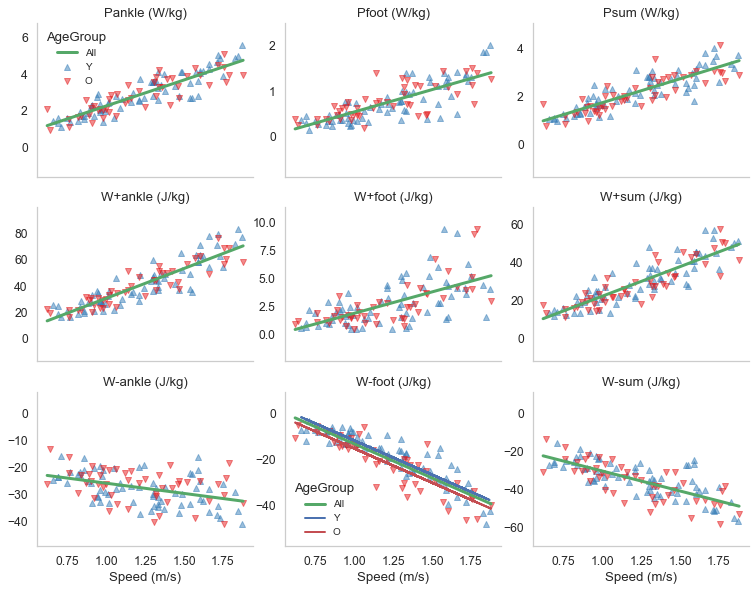

In [11]:
df2 = dfraw.copy(deep=True).reset_index()
var = ['Pankle', 'Pfoot', 'Psum', 'Wpankle', 'Wpfoot', 'Wpsum',
       'Wnankle', 'Wnfoot', 'Wnsum']
varn = ['v'+str(i) for i in range(9)]
df2 = df2.rename(columns=dict(zip(var, varn)), inplace=False)
df2 = pd.wide_to_long(df2, stubnames=['v'],
                      i='index', j='Variable', suffix='\d+').reset_index()

labels = ['Pankle (W/kg)', 'Pfoot (W/kg)', 'Psum (W/kg)', 'W+ankle (J/kg)', 'W+foot (J/kg)',
          'W+sum (J/kg)', 'W-ankle (J/kg)','W-foot (J/kg)','W-sum (J/kg)']
g = sns.lmplot(x='Speed', y='v', hue='AgeGroup', col='Variable', data=df2, markers=['^', 'v'],
               ci=None, line_kws={'linestyle': '--'}, scatter_kws={'alpha':.5}, 
               fit_reg=False, legend_out=False, palette=palette,
               truncate=True, sharex=True, sharey=False, col_wrap=3, height=2.8, aspect=1.3)
g.set_axis_labels('Speed (m/s)', '')
for i, ax in enumerate(g.axes):
    x = fit_re[len(predictor)*i].model.exog[:, -1]*dfraw.iloc[:, 9].std() + dfraw.iloc[:, 9].mean()
    y = fit_re[len(predictor)*i].predict()*dfraw.iloc[:, i+10].std() + dfraw.iloc[:, i+10].mean()
    sns.lineplot(x=x, y=y, ci=None, color='g', alpha=1, lw=3, label='All', ax=ax)
    if i == 7:
        c = fit_re[len(predictor)*i + 2].params  # Wnfoot
        idx = fit_re[len(predictor)*i + 2].model.exog[:, 1] == 0  # young adults
        xy = fit_re[len(predictor)*i + 2].model.exog[idx, -1]  # speed
        yy = c['Intercept'] + c['C(AgeGroup)[T.1]']*0 + c['Speed']*xy
        xy = xy*dfraw.iloc[:, 9].std() + dfraw.iloc[:, 9].mean()
        yy = yy*dfraw.iloc[:, i+10].std() + dfraw.iloc[:, i+10].mean()
        ax.plot(xy, yy, color='b', alpha=1, lw=2, label='Y', linestyle='-')     
        idx = fit_re[len(predictor)*i + 2].model.exog[:, 1] == 1  # older adults
        xo = fit_re[len(predictor)*i + 2].model.exog[idx, -1]  # speed
        yo = c['Intercept'] + c['C(AgeGroup)[T.1]']*1 + c['Speed']*xo
        xo = xo*dfraw.iloc[:, 9].std() + dfraw.iloc[:, 9].mean()
        yo = yo*dfraw.iloc[:, i+10].std() + dfraw.iloc[:, i+10].mean()
        ax.plot(xo, yo, color='r', alpha=1, lw=2, label='O', linestyle='-')
        hands, labs = ax.get_legend_handles_labels()
        ax.legend(hands[:3], labs[:3], frameon=False, loc='best', title='AgeGroup', fontsize=10)

    ax.margins(y=.2)
    ax.set_title(labels[i])
    ax.xaxis.set_major_locator(plt.MultipleLocator(.25))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(.25))
    ax.grid(b=None)  # which='both', alpha=.5
    if i == 0:
        ax.legend(frameon=False, loc='best', title='AgeGroup', fontsize=10)
    elif i == 7:
        pass
    else:
        ax.get_legend().remove()
g.fig.subplots_adjust(wspace=.15, hspace=.2)
plt.show()
g.savefig(os.path.join(path2, 'regression.png'))

In [12]:
fit_re[30].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM   Dependent Variable:   Wnfoot  
No. Observations:   117       Method:               REML    
No. Groups:         39        Scale:                0.1434  
Min. group size:    3         Log-Likelihood:       -73.5298
Max. group size:    3         Converged:            Yes     
Mean group size:    3.0                                     
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.129    0.070   1.825 0.068 -0.009  0.267
C(AgeGroup)[T.1] -0.314    0.110  -2.850 0.004 -0.529 -0.098
Speed            -0.885    0.038 -23.578 0.000 -0.959 -0.812
Group Var         0.066    0.085                            
============================================================

"""

### Partial regression plots of the model for the variable Wnfoot

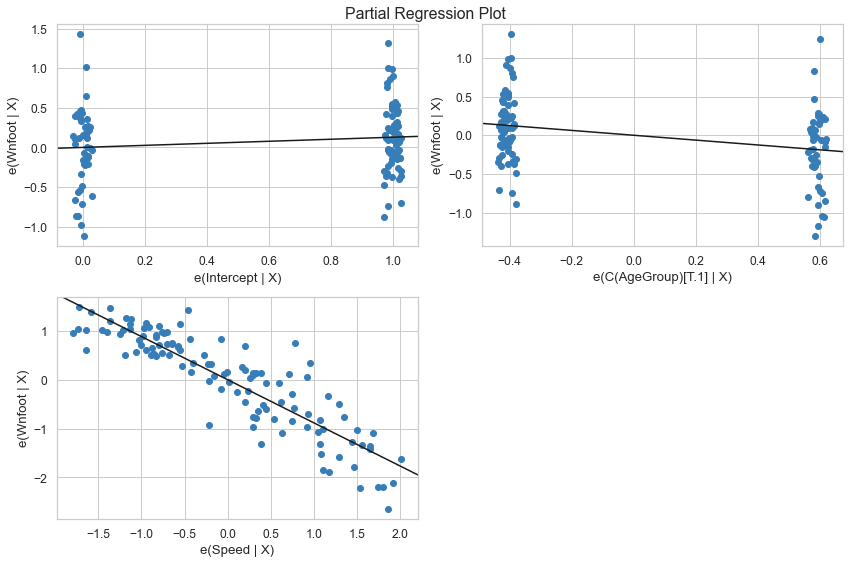

In [13]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(fit_re[30], fig=fig)

#### Plot of the residuals

Plot the residuals only for the significant model ('feature ~ speed').

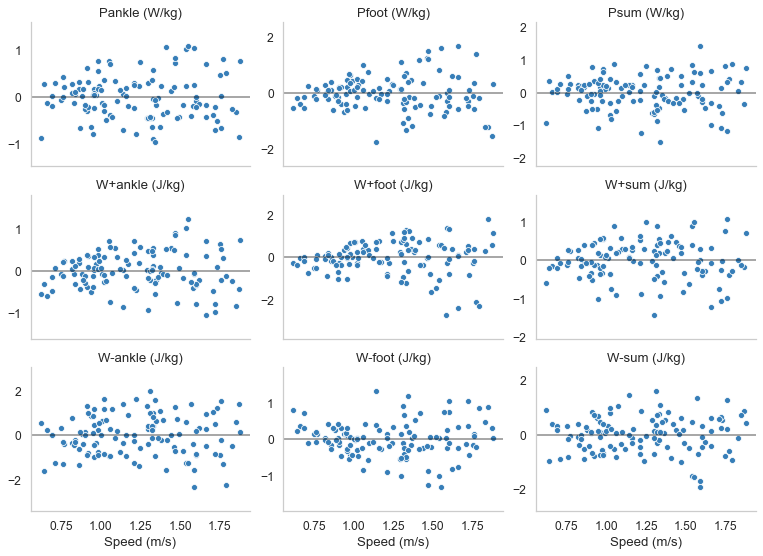

In [14]:
var = ['Pankle', 'Pfoot', 'Psum', 'Wpankle', 'Wpfoot', 'Wpsum',
       'Wnankle', 'Wnfoot', 'Wnsum']
labels = ['Pankle (W/kg)', 'Pfoot (W/kg)', 'Psum (W/kg)', 'W+ankle (J/kg)', 'W+foot (J/kg)',
          'W+sum (J/kg)', 'W-ankle (J/kg)','W-foot (J/kg)','W-sum (J/kg)']
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(13, 9))
axs = axs.flatten()
for i, ax in enumerate(axs):
    speed = fit_re[len(predictor)*i].model.exog[:, 1]*dfraw.iloc[:, 9].std() + dfraw.iloc[:, 9].mean()
    resid = (fit_re[len(predictor)*i].predict()-fit_re[len(predictor)*i].model.endog) # *dfraw.iloc[:, i+10].std()
    sns.scatterplot(x=speed, y=resid, ax=ax)
    if i > 5:
        ax.set_xlabel('Speed (m/s)')
    ax.set_title(labels[i])
    ax.xaxis.set_major_locator(plt.MultipleLocator(.25))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(.25))
    ax.grid(None)  # which='both', alpha=.5
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(0, c='k', alpha=.5)
    ax.margins(y=.25)  

fig.subplots_adjust(wspace=.15, hspace=.2)
plt.show()
fig.savefig(os.path.join(path2, 'residual.png'))